# 前言

## 1. 问题简介

在给定乘客的上车时间，上下车经纬度以及乘客数量的情况下，探索纽约城内打车费用定价模型（包括通行费用）。

由于网约车定价定价标准不固定，不唯一。在同样的框架下，假设我们有滴滴公司的公开数据集，我们将能探究”红包机制“对定价的影响。比如，通过类似的数据分析步骤，可以知道红包在定价中的权重。再考虑到乘客发红包的行为往往与天气，交通堵塞等情况都有密切关系，所以我们还能探究不同情况下红包的大小，做定量比较。更进一步地，可以讲探究出的定价模型与出租车定价做比较，研究网约车定价是否合理。

## 2. 数据集简介
来源：https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data

In [ ]:
import pandas as pd
path ='/Users/ness001/Downloads/train.csv'
train_data=pd.read_csv(path,nrows=10000)

训练集总行数约为5500万行，为了方便探索建模，在此处选取前10万行

In [ ]:
print(train_data.shape)
print(train_data.head(2))
print(train_data.dtypes)
print(train_data.columns)

如上所示，训练集有8个特征值，由上到下分别代表：唯一标示值（由上车时间和唯一整数构成），支付金额，上车的时间，上车的经度，上车的纬度，下车的经度，下车的纬度，乘客人数。其中key和pickup_datatime为object类型变量，若要纳入模型，必须进行处理。

## 3. 实验环境


操作系统：macOS；软件：anaconda(py3.6) + jupyter notebook；使用包：pandas,sklearn,numpy

# 探索性数据分析

为了对数据获得直观印象，列出数据集的前三行，同时输出样本的统计信息，包括样本总数、均值、标准差、最大值、最小值和相关分位数，再做fare_amount以及passenger_count的直方图。

        fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  10000.000000      10000.000000     10000.000000       10000.000000   
mean      11.235464        -72.466660        39.920448         -72.474094   
std        9.584258         10.609729         7.318932          10.579732   
min       -2.900000        -74.438233       -74.006893         -74.429332   
25%        6.000000        -73.992058        40.734547         -73.991112   
50%        8.500000        -73.981758        40.752693         -73.980083   
75%       12.500000        -73.966925        40.767694         -73.963504   
max      180.000000         40.766125       401.083332          40.802437   

       dropoff_latitude  passenger_count  
count      10000.000000     10000.000000  
mean          39.893281         1.644700  
std            6.339919         1.271229  
min          -73.994392         0.000000  
25%           40.735230         1.000000  
50%           40.753738         1.000000  
75%  

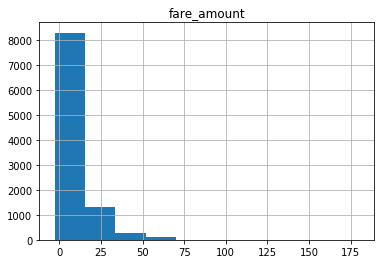

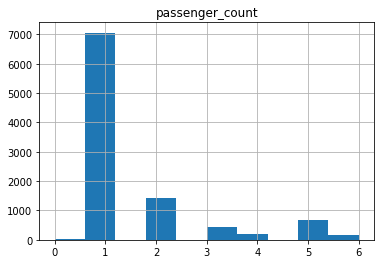

In [69]:
print(train_data.describe())
print(train_data.hist('fare_amount'))
print(train_data.hist('passenger_count'))

从统计表中，很明显可以看出dropoff_longitude以及dropoff_latitude两个特征值的样本个数不足10万，提醒我们接下来需要对缺失值做处理。两张直方图表明支付金额大致在合理范围内（不排除有个别离群点），乘客人数大多为一人。

# 建模前准备：数据修剪

## 1. 缺失值处理

检查各列有多少缺失值，选择处理方法。
常见的缺失值处理方法有  
①删除法：这种方法简单易行，在对象有多个属性缺失值、被删除的含缺失值的对象与信息表中的数据量相比非常小的情况下是非常有效的。  
②插值法：通常基于统计学原理，根据决策表中其余对象取值的分布情况来对一个空值进行填充，从而使信息表完备化。

In [70]:
print(train_data.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


与之前探索性数据分析中一致，下车的经纬度各缺了69个样本，缺失值量并不多，使用删除法直接删除这几行。检查行数以验证是否删除成功。

In [71]:
print('旧行数: %d' % len(train_data))
train_data = train_data.dropna(how = 'any', axis = 'rows')
print('新行数: %d' % len(train_data))

旧行数: 10000
新行数: 10000


## 2. 数值规范化

在数据集介绍部分，已经知道key和pickup_datetime这两个特征值的数据类型为object类型，并且其值是标准的时间格式，所以可以将其转化为datetime类数据。两者表达的含义相同，我们只对key进行处理即可。在此基础上，才可以进一步将年、月、日、时、星期几提取出来。

In [72]:
train_data['key'] = pd.to_datetime(train_data['key'])

In [73]:
data = [train_data]
for i in data:
    i['Year'] = i['key'].dt.year
    i['Month'] = i['key'].dt.month
    i['Date'] = i['key'].dt.day
    i['Day of Week'] = i['key'].dt.dayofweek
    i['Hour'] = i['key'].dt.hour

In [74]:
train_data.head(3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day of Week,Hour
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0


## 3. 反常识值处理

费用不可能是负数。检查删除后数据量。

In [75]:
train_data = train_data.drop(train_data[train_data['fare_amount']<0].index, axis=0)
train_data.shape

(9998, 13)

经调查得，纽约出租车有SUV车型，所以乘客人数不可能超过六个。检查删除后数据量。

In [76]:
train_data = train_data.drop(train_data[train_data['passenger_count']>6].index, axis = 0)
train_data.shape

(9998, 13)

纬度应在正负90之间，经度在正负180之间。检查删除后数据量。

In [77]:
train_data = train_data.drop(((train_data[train_data['pickup_latitude']<-90])|(train_data[train_data['pickup_latitude']>90])).index, axis=0)
train_data = train_data.drop(((train_data[train_data['pickup_longitude']<-180])|(train_data[train_data['pickup_longitude']>180])).index, axis=0)
train_data.shape

(9997, 13)

## 4. 增加/减少特征

最初的几个特征值并未囊括车费定价中最重要的特征：路程长短，所以需要新增特征distance。  
利用球面两点距离的半正矢公式，我们可以利用经纬度计算距离。

In [78]:
import numpy as np
def haversine_distance(lat1, long1, lat2, long2):
    data = [train_data]
    for i in data:
        R = 6371  #radius of earth in kilometers
        
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        i['distance'] = d
    return d
haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
train_data.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day of Week,Hour,distance
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17,1.030764
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,8.450134


## 5. 离群点处理

考虑到数据集是在纽约市内的乘车记录，经纬度之差应该不会太大。
我们新增两个特征：经度之差绝对值，纬度之差绝对值。

In [79]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
add_travel_vector_features(train_data)

做图观察分布，我们有理由相信那些离开“大部队”太远的少数分子是离群点。  
按照图的分布，多次调整下面代码中“500”和“1500”这两个地方的数字，来删减数据。

旧数据量: 9997
新数据量: 9997


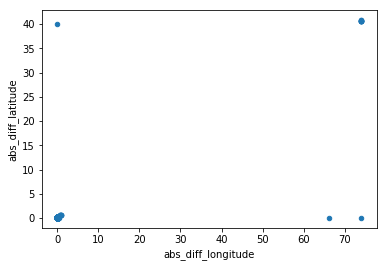

In [80]:
plot = train_data.iloc[0:].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')
print('旧数据量: %d' % len(train_data))
train_data = train_data[(train_data.abs_diff_longitude < 500) & (train_data.abs_diff_latitude < 1500)]
print('新数据量: %d' % len(train_data))

检查一下数据量，发现删减并不多，还算合理，可以进入下一步。

# 初步建模

## 1. 确定目标变量和解释变量

再次检查一下所有特征。

In [81]:
print(train_data.columns)

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'Year', 'Month', 'Date', 'Day of Week', 'Hour',
       'distance', 'abs_diff_longitude', 'abs_diff_latitude'],
      dtype='object')


确定目标变量和解释变量。  
解释变量为上下车经纬度，用来解释地点因素；乘客人数，距离，用来解释耗油因素；年月日时，解释时间在定价中的影响。

In [82]:
y=train_data.fare_amount
features=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude', 'passenger_count', 'distance', 'Year', 'Month', 'Date', 'Day of Week', 'Hour']
X=train_data[features]

## 2. 分离数据

为了方便做模型评估，分离出一部分数据作为验证集。

In [83]:
from sklearn.model_selection import train_test_split
train_X,val_X,train_y,val_y = train_test_split(X,y,random_state=1)

## 3. 训练模型

这是一个回归问题。在此处选用通用性良好的随机森林回归。

In [84]:
from sklearn.ensemble import RandomForestRegressor
betamodel=RandomForestRegressor(n_estimators=10,random_state=1)
betamodel.fit(train_X,train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

## 4. 模型评估

根据验证集特征值，用模型预测出预测值。再使用rmse与r-square进行评估。

In [85]:
preds = betamodel.predict(val_X)

In [86]:
import math
from sklearn.metrics import mean_squared_error
print(math.sqrt(mean_squared_error(val_y,preds)))

from sklearn.metrics import r2_score
print(r2_score(val_y,preds))

5.297516132679541
0.6576229112776311


可见rmse较小，且解释效果有0.77。

## 5. 再次建模

### 方法一：调整模型参数


随机森林回归属于集成学习中的bagging框架，使用cart决策树作为弱学习器。所以需调整：1、调整bagging框架中的参数 2、调整cart决策树内的参数。


bagging框架中最需要关注的参数是  
1）n_estimators: 弱学习器的最大迭代次数。太小，容易欠拟合，太大，计算量会太大，并且n_estimators到一定的数量后，再增大n_estimators获得的模型提升会很小，所以一般选择一个适中的数值。默认是100。  

对于cart决策树中的参数，由于我们特征不多，所以只需调整  
1）内部节点再划分所需最小样本数min_samples_split:  
    这个值限制了子树继续划分的条件。如果某节点的样本数少于min_samples_split，则不会继续再尝试选择最优特征来进行划分。 默认是2，如果样本量数量级非常大，则推荐增大这个值。  
2）叶子节点最少样本数min_samples_leaf:  
    这个值限制了叶子节点最少的样本数。如果某叶子节点数目小于样本数，则会和兄弟节点一起被剪枝。 默认是1,可以输入最少的样本数的整数，或者最少样本数占样本总数的百分比。如果样本量数量级非常大，则推荐增大这个值。

In [93]:
from sklearn.model_selection import GridSearchCV
param_test1 = {'n_estimators':range(80,150,10)}
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(min_samples_split=2,
                                  min_samples_leaf=1,random_state=10), 
                       param_grid = param_test1,scoring='r2',cv=5)
gsearch1.fit(X,y)
print(gsearch1.best_params_, gsearch1.best_score_)

{'n_estimators': 130} 0.7588176515789353


In [ ]:
from sklearn.model_selection import GridSearchCV
param_test2= {'min_samples_split':range(2,20,2),'min_samples_leaf':range(1,10,1)}
gsearch2 = GridSearchCV(estimator = RandomForestRegressor(n_estimators=130,random_state=10), 
                       param_grid = param_test2,scoring='r2',cv=5)
gsearch2.fit(X,y)
print(gsearch2.best_params_, gsearch2.best_score_)

In [ ]:
将挑选出的参数放入模型，重新评估

In [ ]:
from sklearn.ensemble import RandomForestRegressor
newmodel=RandomForestRegressor(n_estimators=130,min_samples_leaf=7,min_samples_split=2,random_state=1)
newmodel.fit(train_X,train_y)
newpreds=newmodel.predict(val_X)
print(math.sqrt(mean_squared_error(val_y,newpreds)))

from sklearn.metrics import r2_score
print(r2_score(val_y,newpreds))

# 后续改进思路

受限于机能，为了方便调参，载入的数据量较少，在导入100，000，000行数据的情况下，第一次训练结果的r2已经高达0.79，如果讲上述的分析框架应用到这些数据，那么效果会更好。